# Imports & Constants

In [39]:

import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.interpolate

In [40]:
# Values of the plates (in cm)
l_y = 5
l_z = 10
d = 1

#----------------------------------------------------------------

#Values of the box (in cm)
L_X = 10
L_Y = 15
L_Z = 30

#----------------------------------------------------------------

DS = 0.1

X_MIN = -5
X_MAX = 5

Y_MIN = -7.5
Y_MAX = 7.5

Z_MIN = -15
Z_MAX = 15

V_1 = 10
V_2 = -5

R_TOL = 1e-2

M_X = 101 
M_Y = 151
M_Z = 301

V_1 = 10
V_2 = -5

## Utilmethods (Meshes, Algorithm ...)

In [41]:
# Preparing  meshes

v_x, v_y, v_z =  np.arange(X_MIN, X_MAX + DS, DS), np.arange(Y_MIN, Y_MAX + DS, DS), np.arange(Z_MIN, Z_MAX + DS, DS)

V = np.zeros((M_X, M_Y, M_Z))

V[46, 51:102, 101:202] = 10
V[56, 51:102, 101:202] = -5

In [42]:
#Useless methods

def x(j, x_min=X_MIN, dx=DS): 
    return x_min + (j-1)*dx  

def y(k, y_min=X_MIN, dy=DS): 
    return y_min + (k-1)*dy  

def z(l, z_min=X_MIN, dz=DS): 
    return z_min + (l-1)*dz  


#-------------------------------

def V_theo(x, V_1=V_1, V_2=V_2, d=d):

    if abs(x) <= d/2:
        return V_2 + (V_1 - V_2) * ( (d - 2*x) / (2*d) ) 
    elif x < -d/2:
        return V_1
    else:
        return V_2

In [43]:
@njit
def algorithm(V:np.array, M_X:int = M_X, M_Y:int = M_Y, M_Z:int = M_Z, r_tol:float = R_TOL) -> np.array: 

    ans = np.copy(V)

    iter = 0
    max_error = 0

    while True:

        iter += 1
        for j in range(1, M_X-1):
            for k in range(1, M_Y-1):
                for l in range(1, M_Z-1):
    
                    if j in (46,56) and (51<=k<=101 and 101<=l<=201): #Not changing the potential at the plates
                        continue

                    node = ans[j,k,l]
                    mean = (ans[j-1,k,l] + ans[j+1,k,l] + ans[j,k+1,l] + ans[j,k-1,l] + ans[j,k,l+1] + ans[j,k,l-1]) / 6
                    ans[j, k, l] = mean

                    error = abs(node-mean)
                    max_error = error if error > max_error else max_error
        
        if max_error < r_tol:             
            return ans
        
        max_error = 0

# Exercises

In [44]:
try:
    V = np.load('potential.npy')
except FileNotFoundError:
    np.save('potential.npy', algorithm(V))
    V = np.load('potential.npy')

## Exercise 1

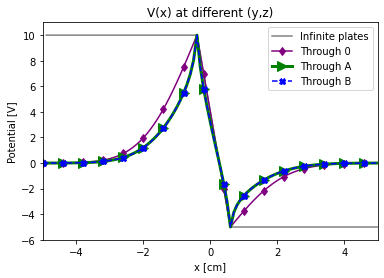

In [45]:
fig, ax = plt.subplots()

plt.title('V(x) at different (y,z)')
plt.ylabel('Potential [V]')
plt.xlabel('x [cm]')

plt.ylim(-5-1, 10+1)
plt.xlim(X_MIN, X_MAX)

ax.plot(v_x+0.1, [V_theo(i) for i in v_x], color='gray', label='Infinite plates')

#Repasar que las posiciones estén bien
ax.plot(v_x, V[:, 76 , 151], color='purple', label='Through 0', marker='d', markevery=6)
ax.plot(v_x, V[:, 51 , 151], color='green', label='Through A', marker='>', markevery=6, markersize=10, linewidth=3) 
ax.plot(v_x, V[:, 76 , 101], color='blue', label='Through B', marker='X', markevery=6, linestyle='--')

plt.legend()
plt.show()


## Exercise 2

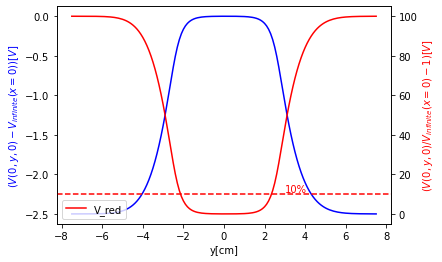

In [46]:
def difference(x1:float, x2:float) -> float:
    # per % difference, definida por él.
    return  abs(x1-x2)/(x2) * 100

_ , ax = plt.subplots()
ax2 = ax.twinx()

ax.set_ylabel('$(V(0,y,0) - V_{infinite}(x=0))[V]$', color='blue')
ax2.set_ylabel('$(V(0,y,0)/V_{infinite}(x=0) - 1)[V]$', color='red')
ax.set_xlabel('y[cm]')

ax.plot(v_y, V[51, : , 150] - V_theo(0), color='blue', label='V_blue') 

ax2.plot(v_y, difference(V[51, : , 150], V_theo(0)), color='red', label='V_red')
ax2.axhline(10, color='red', linestyle='--')
ax2.text(3, 11, '10%', color = 'red')

plt.legend()
plt.show()

## Section 1 

In [47]:
y_interp = scipy.interpolate.interp1d(v_y, difference(V[51, : , 150], V_theo(0)))
print(*[f'Beyond x= {x} the difference is larger than {round(float(y_interp(x)),1)}%'  for x in np.arange(2.337,2.3371,0.0001)])
print(*[f'Beyond x= {x} the difference is larger than {round(float(y_interp(x)),1)}%'  for x in np.arange(-2.1350,-2.13499,0.0001)])
print('Percentage difference at the left edge of the finite capacitor:', round(float(y_interp(-2.5)),2),'%')

Beyond x= 2.337 the difference is larger than 10.0%
Beyond x= -2.135 the difference is larger than 10.0%
Percentage difference at the left edge of the finite capacitor: 25.84 %


## Section 2

In [49]:
print('Percentage difference at the left edge of the finite capacitor:', round(float(y_interp(-2.5)),2),'%')

Percentage difference at the left edge of the finite capacitor: 25.84 %


## Exercise 3

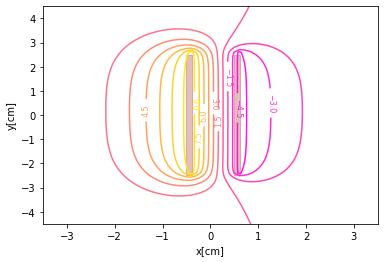

In [48]:
_, ax = plt.subplots()

ax.set_ylim(-4.5, 4.5)
ax.set_xlim(-3.5, 3.5)

ax.set_ylabel('y[cm]')
ax.set_xlabel('x[cm]')

ax.add_patch(plt.Rectangle((-0.5,-2.5), 0.125, 5, color='brown', alpha=0.3 ))
ax.add_patch(plt.Rectangle((0.5,-2.5), 0.125, 5, color='brown', alpha=0.3 ))

c = ax.contour(v_x, v_y, V[:, : , 151].T, levels=11, cmap='spring')
ax.clabel(c, inline=1, fontsize=8) 

plt.show()